# Mini Project: Modeling & Simulation
## Optimization: Comparison between batch, stochastic and mini-batch techniques
---
**Created by:** Harold H. Rodriguez R.\
**Contact:** rodriguezhh03@gmail.com

### Introduction

This mini-project consists of comparing different optimization techniques: batch, stochastic, and mini-batch.

**First Part:**
In the first part, the comparison of the techniques is carried out using gradient descent as the optimization method. Additionally, an analysis of the obtained results will be included.

**Second Part:**
In the second part, at least one different optimization method will be tested and the results will be compared against gradient descent.


### Data Generation with Matlab
Output data was generated based on a Matlab system as follows:
```matlab
A = [1  -1.5  0.7];
B = [0 1 0.5];
sys0 = idpoly(A,B);
u = iddata([],idinput(10000,'rbs'));
e = iddata([],randn(10000,1));
y = sim(sys0,[u e]);
```
With the generated vectors "u" and "y", I created a .dat file with 10000 samples and 2 columns respectively, and saved it as follows:
```matlab
yv = y.OutputData;
uv = u.InputData;
data = [uv,yv];
filename = 'output.dat';
dlmwrite(filename, data, 'delimiter', '\t', 'precision', 6);
```

### System Identification with an ARMAX Model

The system identification model used was the ARMAX model, which in discrete domain is defined as follows: \
$A(z)y(t)=B(z)u(t)+C(z)e(t)$ \
And the time domain definition would be given as follows:

$
\hat{y}(t) = -a_1 y(t-1) - ... - a_n y(t-n_a) + b_1 u(t-1) + ... + b_n u(t-n_b) + c_1 e(t-1) + ... + c_n e(t-n_c)
$

Where:
- $a_1, a_2$ are the autoregressive coefficients.
- $b_1, b_2$ are the coefficients of the exogenous terms.
- $c_1, c_2$ are the coefficients of the moving average terms (errors).
- $e(t-1), e(t-2)$ are the prediction errors at times $(t-1)$ and $(t-2)$, respectively.

The term $e(t)$ represents the prediction error at time $t$, and is calculated as the difference between the actual output and the predicted output: $e(t) = y(t) - \hat{y}(t)$.

The ARMAX model incorporates past prediction errors into the prediction equation to capture more information about the system dynamics and improve prediction accuracy.

### Resultado al usar ARMAX en Matlab
Como punto de comparación en el desempeño se tendra el resultado proporcionado por matlab, el cual es el siguiente:

```matlab
h =
Discrete-time ARMAX model: A(z)y(t) = B(z)u(t) + C(z)e(t)
  A(z) = 1 - 1.506 z^-1 + 0.7076 z^-2                    
                                                         
  B(z) = 1.001 z^-1 + 0.5009 z^-2                        
                                                         
  C(z) = 1 + 0.003257 z^-1                               
                                                         
Sample time: 1 seconds
  
Parameterization:
   Polynomial orders:   na=2   nb=2   nc=1   nk=1
   Number of free coefficients: 5
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                          
Estimated using ARMAX on time domain data "sys0".
Fit to estimation data: 81.04% (prediction focus)
FPE: 1.003, MSE: 1.002  

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

### Load data

In [2]:
# Ruta al archivo .dat en tu Google Drive
file_path = 'output.dat'

# Lee el archivo .dat como una matriz NumPy
data = np.loadtxt(file_path)

## First part

### Batch tecnique

### Functions

In [3]:
# Definimos la función de costo llamada "mean_square_error"
def mean_square_error_batch(data, y_pred):
    # Extraemos la segunda columna de 'data' que contiene los valores reales 'y'
    y = data[:, 1]

    # Calculamos el error restando las predicciones 'y_pred' de los valores reales 'y' a partir del tercer elemento
    error = y[2:] - y_pred

    # Calculamos la suma de los cuadrados de los errores
    error_sum = np.sum(error ** 2)

    # Calculamos el costo dividiendo la suma de los cuadrados de los errores por el número de elementos - 2
    cost = error_sum / (len(y) - 2)

    # Retornamos el valor del costo
    return cost

In [4]:
def armax_predict_batch(data, weights):
    """
    Predicts the output using the ARMAX model for a batch of data points.

    Parameters:
    data (array): The dataset, where columns correspond to features and target values.
    weights (array): The weights of the ARMAX model.

    Returns:
    array: An array of predicted output values.
    """
    # Extract the first column of 'data' which contains the values of 'u'
    u = data[:, 0]
    # Extract the second column of 'data' which contains the actual values 'y'
    y = data[:, 1]
    
    # Calculate the length of the target values
    n = len(y)
    # Initialize an array to store the predicted output values
    y_hat = np.zeros(n)

    # Unpack the weights into five variables: a1, a2, b1, b2, c1
    a1, a2, b1, b2, c1 = weights

    # Loop over the target values starting from index 2
    for t in range(2, n):
        # Calculate the predicted output using the ARMAX model equation
        y_hat[t] = - a1 * y[t-1] - a2 * y[t-2] + b1 * u[t-1] + b2 * u[t-2] + c1 * (y[t-1] - y_hat[t-1])

    # Return the predicted output values, excluding the first two values (as they are not predicted)
    return y_hat[2:]


In [5]:
def gradient_batch(cost_function, weights, data):
    """
    Calcula el gradiente de una función f con respecto a un vector x.

    Args:
        f (función): La función para la cual se calculará el gradiente.
        x (numpy.ndarray): El punto en el que se calculará el gradiente.

    Returns:
        numpy.ndarray: El vector gradiente.
    """
    epsilon = 1e-6  # Valor pequeño para la diferenciación numérica
    n = len(weights)  # Número de variables
    grad = np.zeros(n)  # Inicializa el vector gradiente

    for i in range(n):
        # Perturba la i-ésima componente de x
        x_perturbado = weights.copy()
        x_perturbado[i] += epsilon

        # Calcula la derivada parcial utilizando la diferencia central
        grad[i] = (cost_function(data, armax_predict_batch(data,x_perturbado)) - cost_function(data, armax_predict_batch(data,weights))) / epsilon

    return grad

In [6]:
def batch_train(data, cost_function, epochs, learning_rate=0.01):
    """
    Trains the model using batch gradient descent.

    Parameters:
    data (array): The dataset, where columns correspond to features and target values.
    cost_function (function): The function used to compute the cost (e.g., mean squared error).
    epochs (int): The number of iterations for training.
    learning_rate (float, optional): The step size for updating the weights. Default is 0.01.

    Returns:
    tuple: The final weights and the cost history over epochs.
    """
    # Initialize weights to zero (for a model with four parameters)
    weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    # Initialize an array to store the cost at each epoch
    cost = np.zeros(epochs)

    start_time = time.time()  # Inicio de la medición del tiempo

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Predict the output using the current weights
        y_pred = armax_predict_batch(data, weights)
        # Calculate the mean squared error using the cost function
        mse = cost_function(data, y_pred)
        # Store the cost for the current epoch
        cost[epoch] = mse
        # Compute the gradient of the cost function with respect to the weights
        grad = gradient_batch(cost_function, weights, data)
        # Update the weights by moving in the direction of the negative gradient
        weights = weights - learning_rate * grad

        # Print the current epoch, cost, and weights
        print(str(epoch + 1) + '/' + str(epochs) + '--------------------------------------------------------------------------')
        print('MSE = ', mse, 'Weights = ', weights)

    end_time = time.time()  # Fin de la medición del tiempo
    elapsed_time = end_time - start_time  # Cálculo del tiempo transcurrido

    # Return the final weights and the cost history
    return weights, cost, elapsed_time


In [7]:
def plot_cost(cost_values):
    """
    Plots the cost values over epochs.

    Parameters:
    cost_values (list or array): A list or array of cost values for each epoch.

    """
    # Generate an array of epoch numbers
    epochs = range(1, len(cost_values) + 1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, cost_values, linestyle='-', color='b', label='Cost')
    
    # Add titles and labels
    plt.title('Cost per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    
    # Add a grid
    plt.grid(True)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

### Training

For the development of this project and in order to compare the performance of each technique (batch, stochastic, and mini-batch), the same parameters and hyperparameters were used in all trainings. Mainly, 100 epochs and a learning rate of 0.001 are established.

The ARX model built for prediction consists of $a_n=2$, $b_n=2$, and $c_n=1$.

In [8]:
weights_batch, cost_batch, time_batch = batch_train(data, mean_square_error_batch, 100, learning_rate=0.001)
print('El valor de los coeficientes en la epoca 100 es a1='+str(weights_batch[0])
      +' a2='+str(weights_batch[1])+' b1='+str(weights_batch[2])+' b2='+str(weights_batch[3])
      +' c1='+str(weights_batch[4]))
print('Elapsed time: '+str(time_batch)+' seconds')

1/100--------------------------------------------------------------------------
MSE =  27.52275730205167 Weights =  [-0.04901698 -0.0346945   0.00190773  0.003907    0.04901689]
2/100--------------------------------------------------------------------------
MSE =  22.11449862907691 Weights =  [-0.08985816 -0.06239018  0.00364814  0.00743036  0.08674426]
3/100--------------------------------------------------------------------------
MSE =  18.56748182513421 Weights =  [-0.12499106 -0.08521749  0.00528201  0.01068811  0.11736523]
4/100--------------------------------------------------------------------------
MSE =  16.057121933620422 Weights =  [-0.15583607 -0.10440178  0.00684164  0.01374645  0.14310852]
5/100--------------------------------------------------------------------------
MSE =  14.19064060524876 Weights =  [-0.18330694 -0.12073134  0.0083464   0.01664698  0.16531045]
6/100--------------------------------------------------------------------------
MSE =  12.753466069394415 Wei

### Cost Function Plot

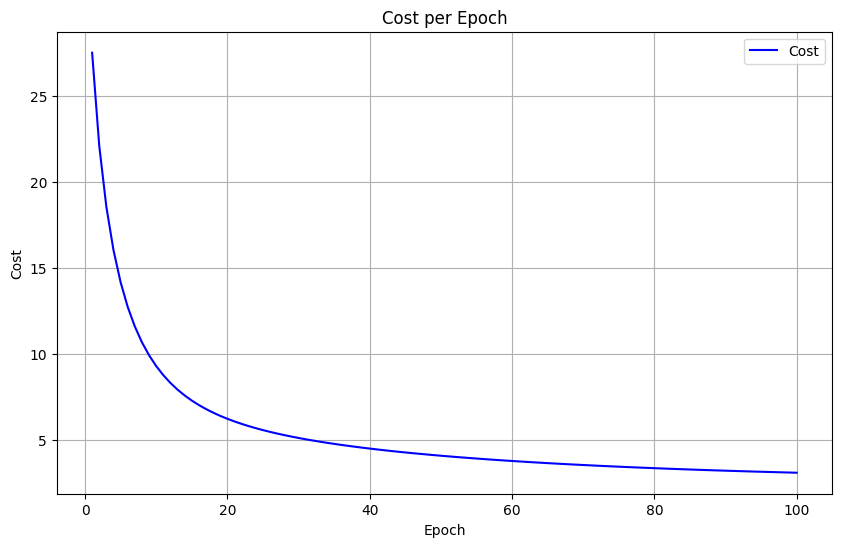

In [9]:
plot_cost(cost_batch)

### Stochastic tecnique

### Functions

In [10]:
# Definimos la función de costo llamada "mean_square_error"
def mean_square_error_stochastic(data, y_pred, index):
    # Extraemos la segunda columna de 'data' que contiene los valores reales 'y'
    y = data[:, 1]

    # Calculamos el error restando las predicciones 'y_pred' de los valores reales 'y' a partir del tercer elemento
    error = y[index] - y_pred

    # Calculamos la suma de los cuadrados de los errores
    error_sum = np.sum(error ** 2)

    # Calculamos el costo dividiendo la suma de los cuadrados de los errores por el número de elementos - 2
    cost = error_sum / 1

    # Retornamos el valor del costo
    return cost

In [11]:
def predict_stochastic(data, y_hat, weights, index):
    # Extract the first column of 'data' which contains the values of 'u'
    u = data[:, 0]
    # Extract the second column of 'data' which contains the actual values 'y'
    y = data[:, 1]

    # Unpack the weights into four variables: a1, a2, b1, and b2
    a1, a2, b1, b2, c1 = weights

    # Calculate the predictions 'y_pred' using the provided formula
    # Utilize the shifted values of 'y' and 'u' to create the predictions
    y_pred = -a1 * y[index-1] - a2 * y[index-2] + b1 * u[index-1] + b2 * u[index-2] + c1 * (y[index-1]-y_hat[index-1])

    # Return the array of predictions 'y_pred'
    return y_pred

In [12]:
def gradient_stochastic(cost_function, weights, data, y_hat, index):
    """
    Calcula el gradiente de una función f con respecto a un vector x.

    Args:
        f (función): La función para la cual se calculará el gradiente.
        x (numpy.ndarray): El punto en el que se calculará el gradiente.

    Returns:
        numpy.ndarray: El vector gradiente.
    """
    epsilon = 1e-6  # Valor pequeño para la diferenciación numérica
    n = len(weights)  # Número de variables
    grad = np.zeros(n)  # Inicializa el vector gradiente

    for i in range(n):
        # Perturba la i-ésima componente de x
        x_perturbado = weights.copy()
        x_perturbado[i] += epsilon

        # Calcula la derivada parcial utilizando la diferencia central
        grad[i] = (cost_function(data, predict_stochastic(data, y_hat,x_perturbado, index),index) - cost_function(data, predict_stochastic(data, y_hat,weights, index),index)) / epsilon

    return grad

In [13]:
def stochastic_train(data, cost_function, epochs, learning_rate=0.01):
    """
    Trains the model using stochastic gradient descent.

    Parameters:
    data (array): The dataset, where columns correspond to features and target values.
    cost_function (function): The function used to compute the cost (e.g., mean squared error).
    epochs (int): The number of iterations for training.
    learning_rate (float, optional): The step size for updating the weights. Default is 0.01.

    Returns:
    tuple: The final weights and the cost history over epochs.
    """
    # Initialize weights to zero (for a model with four parameters)
    weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    # Initialize an array to store the cost at each epoch
    cost = np.zeros(epochs)

    # Initialize an array to store the predicted output values
    y_pred = np.zeros(len(data))

    start_time = time.time()  # Inicio de la medición del tiempo

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Create a list of available indices (excluding the first two)
        available_indices = list(range(2, len(data)))
        # Loop over the dataset, starting from index 2 to the end
        for sample in range(2, len(data)):
            # Select a random index from the available indices
            selected_index = random.choice(available_indices)
            # Predict the output for the selected sample using the current weights
            y_pred[sample] = predict_stochastic(data, y_pred, weights, selected_index)
            # Compute the gradient of the cost function for the selected sample
            grad = gradient_stochastic(cost_function, weights, data, y_pred, selected_index)
            # Update the weights using the computed gradient
            weights = weights - learning_rate * grad
            # Remove the selected index from the list of available indices
            available_indices.remove(selected_index)
        
        # Compute the mean squared error for the entire batch
        mse = mean_square_error_batch(data, armax_predict_batch(data, weights))
        # Store the cost for the current epoch
        cost[epoch] = mse

        # Print the current epoch, cost, and weights
        print(str(epoch + 1) + '/' + str(epochs) + '--------------------------------------------------------------------------')
        print('MSE = ', mse, 'Weights = ', weights)

    end_time = time.time()  # Fin de la medición del tiempo
    elapsed_time = end_time - start_time  # Cálculo del tiempo transcurrido

    # Return the final weights and the cost history
    return weights, cost, elapsed_time

### Training

For the development of this project and in order to compare the performance of each technique (batch, stochastic, and mini-batch), the same parameters and hyperparameters were used in all trainings. Mainly, 100 epochs and a learning rate of 0.001 are established.

The ARX model built for prediction consists of $a_n=2$, $b_n=2$, and $c_n=1$.

In [14]:
weights_stochastic, cost_stochastic, time_stochastic = stochastic_train(data, mean_square_error_stochastic, 100, learning_rate=0.001)
print('El valor de los coeficientes en la epoca 100 es a1='+str(weights_stochastic[0])
      +' a2='+str(weights_stochastic[1])+' b1='+str(weights_stochastic[2])+' b2='+str(weights_stochastic[3])
      +' c1='+str(weights_stochastic[4]))
print('Elapsed time: '+str(time_stochastic)+' seconds')

1/100--------------------------------------------------------------------------
MSE =  1.016591922404926 Weights =  [-1.49748412  0.69672124  1.0328287   0.58191036  0.01396661]
2/100--------------------------------------------------------------------------
MSE =  1.0115733867300958 Weights =  [-1.50666232  0.70683626  0.97597929  0.54285675 -0.04140005]
3/100--------------------------------------------------------------------------
MSE =  1.1132252253409158 Weights =  [-1.50114122  0.64391806  0.96284618  0.50368902 -0.01933628]
4/100--------------------------------------------------------------------------
MSE =  1.1159017324467444 Weights =  [-1.55217288  0.69144023  0.94056133  0.51046332  0.04549327]
5/100--------------------------------------------------------------------------
MSE =  1.064284838721865 Weights =  [-1.50296447  0.66234668  1.01879423  0.4579496   0.10254244]
6/100--------------------------------------------------------------------------
MSE =  1.010315383837316 We

### Cost Function Plot

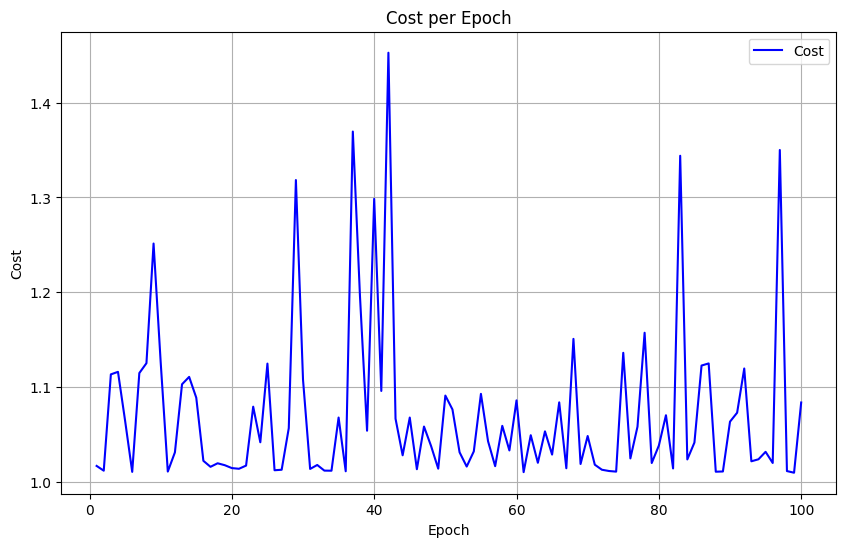

In [15]:
plot_cost(cost_stochastic)

### Mini-batch Technique

### Functions

In [16]:
def create_batches(data, batch_size):
    """
    Divide a vector into batches of a specified size.

    Parameters:
    data (array): The input vector containing M data points.
    batch_size (int): The size of each batch.

    Returns:
    list: A list of arrays, each array representing a batch of data.
    """
    # Calculate the total number of batches needed
    num_batches = (len(data) + batch_size - 1) // batch_size

    # Create a list to store the batches
    batches = []

    # Loop over the number of batches
    for i in range(num_batches):
        # Calculate the start index of the current batch
        start_idx = i * batch_size
        # Calculate the end index of the current batch
        end_idx = min((i + 1) * batch_size, len(data))
        # Extract the current batch from the input data and append it to the list of batches
        batches.append(data[start_idx:end_idx])

    # Return the list of batches
    return batches

In [17]:
def minibatch_train(data, cost_function, epochs, batch_size, learning_rate=0.01):
    """
    Trains the model using minibatch gradient descent.

    Parameters:
    data (array): The dataset, where columns correspond to features and target values.
    cost_function (function): The function used to compute the cost (e.g., mean squared error).
    epochs (int): The number of iterations for training.
    batch_size (int): The size of each minibatch.
    learning_rate (float, optional): The step size for updating the weights. Default is 0.01.

    Returns:
    tuple: The final weights, the cost history over epochs, and the elapsed time for training.
    """
    # Initialize weights to zero (for a model with five parameters)
    weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    # Initialize an array to store the cost at each epoch
    cost = np.zeros(epochs)
    # Create minibatches from the dataset
    batches = create_batches(data, batch_size)

    start_time = time.time()  # Start measuring time

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Create a list of available indices (corresponding to minibatches)
        available_indices = list(range(len(batches)))
        # Loop over the minibatches
        for _ in range(len(batches)):
            # Select a random index from the available indices
            selected_index = random.choice(available_indices)
            # Compute the gradient of the cost function for the selected minibatch
            grad = gradient_batch(cost_function, weights, batches[selected_index])
            # Update the weights using the computed gradient
            weights = weights - learning_rate * grad
            # Remove the selected index from the list of available indices
            available_indices.remove(selected_index)

        # Predict the output for the entire dataset using the updated weights
        y_pred = armax_predict_batch(data, weights)
        # Compute the mean squared error for the entire dataset
        mse = cost_function(data, y_pred)
        # Store the cost for the current epoch
        cost[epoch] = mse

        # Print the current epoch, cost, and weights
        print(str(epoch + 1) + '/' + str(epochs) + '--------------------------------------------------------------------------')
        print('MSE = ', mse, 'Weights = ', weights)

    end_time = time.time()  # End measuring time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Return the final weights, the cost history, and the elapsed time for training
    return weights, cost, elapsed_time

### Training

For the development of this project and in order to compare the performance of each technique (batch, stochastic, and mini-batch), the same parameters and hyperparameters were used in all trainings. Mainly, 100 epochs and a learning rate of 0.001 are established.

The ARX model built for prediction consists of $a_n=2$, $b_n=2$, and $c_n=1$.

In [18]:
weights_minibatch, cost_minibatch, time_minibatch = minibatch_train(data, mean_square_error_batch, 100, 32, learning_rate=0.001)
print('El valor de los coeficientes en la epoca 100 es a1='+str(weights_stochastic[0])
      +' a2='+str(weights_stochastic[1])+' b1='+str(weights_stochastic[2])+' b2='+str(weights_stochastic[3])
      +' c1='+str(weights_stochastic[4]))
print('Elapsed time: '+str(time_minibatch)+' seconds')

1/100--------------------------------------------------------------------------
MSE =  2.016534844578691 Weights =  [-0.99909356  0.23250086  0.36277021  0.28335309  0.50565703]
2/100--------------------------------------------------------------------------
MSE =  1.3323554736720842 Weights =  [-1.26780596  0.48756357  0.61474309  0.40644763  0.30379268]
3/100--------------------------------------------------------------------------
MSE =  1.0950387315830314 Weights =  [-1.40879449  0.61254148  0.77339236  0.47224688  0.16201012]
4/100--------------------------------------------------------------------------
MSE =  1.0305696611148623 Weights =  [-1.47203549  0.66849984  0.86710113  0.50064939  0.07842729]
5/100--------------------------------------------------------------------------
MSE =  1.0136057063924364 Weights =  [-1.48674526  0.69276785  0.91813524  0.50533219  0.03726295]
6/100--------------------------------------------------------------------------
MSE =  1.0111211671559068 

### Cost Function Plot

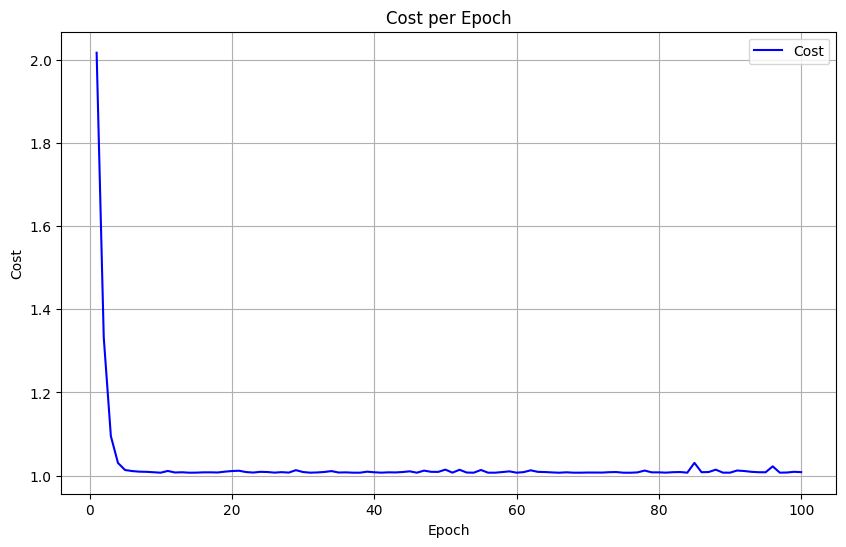

In [19]:
plot_cost(cost_minibatch)